In [102]:
using WAV
using MFCC
using Plots
using MATLAB
using Distances

include("../utils.jl")

find_peaks (generic function with 1 method)

In [103]:
# adding path and function to matlab engine

mat"addpath('../matlab;../matlab/AnalysisTools;../matlab/BlackCat;../matlab/ColoredNoise;../matlab/ModerMouthNoise;../matlab/RDP_demos;../matlab/STCode;../matlab/STCode/VocalTractData;../matlab/STCode/VokalTrakt_SideBranch;../matlab/SineWaveSpeech;../matlab/TubeTalkerMain;')"


In [104]:
function display_rdp(
    rdp_matrix::Matrix{Float64}
)
    param_names = [
        "LABEL",
        "RDP 1",
        "RDP 2",
        "RDP 3",
        "μ/ETC",
        "TMI",
        "GWI",
        "SKW",
        "STI",
        "CFLAG"
    ]

    for i in 1:length(param_names)
        arr = rdp_matrix[i, :]
        padded = []
        for j in 1:length(arr)
            new = string(round(arr[j], digits=2))
            if length(split(new, ".")[2]) < 2
                new = new * "0"
            end
            if occursin("-", new) == false
                new = "+" * new
            end
            while length(split(new, ".")[1]) < 5
                new = " " * new
            end
            push!(padded, new)
        end
        g = 8 - length(param_names[i])
        println("\e[32m$(param_names[i])\e[0m", " "^g, join(padded, "\e[34m|\e[0m"))
        l = length(join(padded, "|"))
        print(" "^8)
        println("\e[34m$('-'^l)")
    end
    
end

function get_cost_matrix(
    m1,
    m2,
    search_range=20
)
    m1_frames = length(m1[:, 1])
    m2_frames = length(m2[:, 1])
    cost_matrix = zeros(m1_frames, m2_frames)
    for i in 1:m1_frames # for each window
        for j in 1:m2_frames # for each window
            v1 = m1[i, :]
            v2 = m2[j, :]
            # display(v1)
            # display(v2)
            cost = euclidean(v1, v2)
            cost_matrix[i, j] = cost
        end
    end
    y = range(1, m1_frames)
    x = []
    for i in 1:m1_frames
        scaled_center = Int64(round((i/m1_frames)*m2_frames))
        # println("i=", i, " ", scaled_center, " out of ", m2_frames)
        if scaled_center > search_range && scaled_center < m2_frames-search_range
            # println("searching ", scaled_center-search_range, ":", scaled_center+search_range, " ", cost_matrix[i, scaled_center-search_range:scaled_center+search_range], " got ", argmin(cost_matrix[i, scaled_center-search_range:scaled_center+search_range]))
            push!(x, argmin(cost_matrix[i, scaled_center-search_range:scaled_center+search_range])+scaled_center-search_range-1)
        elseif scaled_center <= search_range
            # println("searching ", 1, ":", scaled_center+search_range, " ", cost_matrix[i, 1:scaled_center+search_range], " got ", argmin(cost_matrix[i, 1:scaled_center+search_range]))
            push!(x, argmin(cost_matrix[i, 1:scaled_center+search_range]))
        elseif scaled_center >= m2_frames-search_range
            # println("searching ", scaled_center-search_range, ":end", " ", cost_matrix[i, scaled_center-search_range:end], " got ", argmin(cost_matrix[i, scaled_center-search_range:end]))
            push!(x, argmin(cost_matrix[i, scaled_center-search_range:end])+scaled_center-search_range-1)
        else
            print("ERROR")
        end
        # println("index ", argmin(cost_matrix[i, :]), " is ", cost_matrix[i, :][argmin(cost_matrix[i, :])])
        # println(cost_matrix[i, :])
    end

    return cost_matrix, (x, y)
end

function windows_to_time(
    matrix,
    time_over_frame::Float64
)
    dims = size(matrix)
    windows1 = range(1, dims[2])
    windows2 = range(1, dims[1])
    time1 = windows1 .* time_over_frame
    time2 = windows2 .* time_over_frame
    return (time1, time2) 
end

function from_rdp_matrix(
    rdp_matrix::Matrix{Float64}
)
    vow_con = []
    add = []
    press = []
    nas = []
    fo = []
    for i in 1:length(rdp_matrix[1, :])
        rdp = rdp_matrix[:, i]
        label = rdp[1]
        if label == 1 # consonants & vowels
            push!(vow_con, mxcellarray(rdp[2:end]))
        elseif label == 2 # adduction
            push!(add, mxcellarray(rdp[5:9]))
        elseif label == 3 # subglottal pressure
            push!(press, mxcellarray(rdp[5:9]))
        elseif label == 4 # nasality
            push!(nas, mxcellarray(rdp[5:9]))
        elseif label == 5 # fo
            push!(fo, mxcellarray(rdp[5:9]))
        else
            println("ERROR")
        end
        # println(rdp)
    end

    result = mxcall(
        :RDP_generator, # name of matlab function
        1, # number of output variables (just waveform in this case)
        100.0, # n
        0.0, # cflag
        1.0, # piri_1
        0.8, # piri_2
        0.7, # piri_3
        0.4, # piri_4
        120.0, # fotarg
        1.5, # lo
        0.3, # to
        0.065, # x02
        0.05, # xib
        0.85, # np
        0.002, # pgap
        8000.0, # pl
        500.0, # nzbw_1
        3000.0, # nzbw_2
        500.0, # nzbw2_1
        3000.0, #nzbw2_2
        mxcellarray(vow_con),
        mxcellarray(add),
        mxcellarray(press),
        mxcellarray(nas),
        mxcellarray(fo)
    )
    return result
end

function get_alignment_curve(
    path
)
    ideal = (range(1, length(path[1])), range(1, length(path[2])))
    alignment_curve = []
    for i in 1:length(ideal[1])
        if path[1][i] < ideal[1][i]
            push!(alignment_curve, path[1][i]-ideal[1][i])
            # println("ideal=", ideal[1][i], " path=", path[1][i], " dif=", path[1][i]-ideal[1][i])
        elseif path[1][i] > ideal[1][i]
            push!(alignment_curve, path[1][i]-ideal[1][i])
        else
            push!(alignment_curve, 0)
        end
    end
    return alignment_curve
end

using Statistics

function get_potential_nudges(
    alignment_curve,
    n
)

    ma = mov_avg(alignment_curve, n)

    _, p_peaks = find_peaks(x=range(1, length(ma)), y=ma)
    _, n_peaks = find_peaks(x=range(1, length(ma)), y=-1 .* ma)

    peaks = sort(vcat(n_peaks, p_peaks))
    magnitudes = []
    for i in 1:length(peaks)
        push!(magnitudes, alignment_curve[peaks[i]])
    end

    rdp_centre = median(range(peaks[1], peaks[end]))
    nudge_magnitude = mean(ma[peaks[1]:peaks[end]])

    return peaks, magnitudes, rdp_centre, nudge_magnitude
end

function mov_avg(vs, n)
    return [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]
end

mov_avg (generic function with 1 method)

In [105]:
vcv1_simple_rdp = [
    2.0 3.0 1.0 4.0 2.0 3.0 5.0;
    0.0 0.0 -1.0 0.0 0.0 0.0 0.0;
    0.0 0.0 1.0 0.0 0.0 0.0 0.0;
    0.0 0.0 1.0 0.0 0.0 0.0 0.0;
    0.03 -1.0 1.0 0.0 0.05 -1.0 0.0;
    1.0 1.0 35.0 35.0 100.0 100.0 100.0;
    20.0 5.0 15.0 30.0 20.0 5.0 30.0;
    1.0 1.0 1.0 1.0 1.0 1.0 1.0;
    0.0 0.0 10.0 10.0 0.0 0.0 0.0;
    0.0 0.0 0.0 0.0 0.0 0.0 0.0;
]

display_rdp(vcv1_simple_rdp)

LABEL      +2.00|   +3.00|   +1.00|   +4.00|   +2.00|   +3.00|   +5.00
        --------------------------------------------------------------
RDP 1      +0.00|   +0.00|   -1.00|   +0.00|   +0.00|   +0.00|   +0.00
        --------------------------------------------------------------
RDP 2      +0.00|   +0.00|   +1.00|   +0.00|   +0.00|   +0.00|   +0.00
        --------------------------------------------------------------
RDP 3      +0.00|   +0.00|   +1.00|   +0.00|   +0.00|   +0.00|   +0.00
        --------------------------------------------------------------
μ/ETC      +0.03|   -1.00|   +1.00|   +0.00|   +0.05|   -1.00|   +0.00
        --------------------------------------------------------------
TMI        +1.00|   +1.00|  +35.00|  +35.00| +100.00| +100.00| +100.00
        --------------------------------------------------------------
GWI       +20.00|   +5.00|  +15.00|  +30.00|  +20.00|   +5.00|  +30.00
        --------------------------------------------------------------
SKW   

In [106]:
vcv2_simple_rdp = [
    2.0 3.0 1.0 4.0 2.0 3.0 5.0;
    0.0 0.0 -1.0 0.0 0.0 0.0 0.0;
    0.0 0.0 1.0 0.0 0.0 0.0 0.0;
    0.0 0.0 1.0 0.0 0.0 0.0 0.0;
    0.03 -1.0 1.0 0.0 0.05 -1.0 0.0;
    1.0 1.0 20.0 35.0 100.0 100.0 100.0;
    20.0 5.0 15.0 30.0 20.0 5.0 30.0;
    1.0 1.0 1.0 1.0 1.0 1.0 1.0;
    0.0 0.0 10.0 10.0 0.0 0.0 0.0;
    0.0 0.0 0.0 0.0 0.0 0.0 0.0;
]

display_rdp(vcv2_simple_rdp)

LABEL      +2.00|   +3.00|   +1.00|   +4.00|   +2.00|   +3.00|   +5.00
        --------------------------------------------------------------
RDP 1      +0.00|   +0.00|   -1.00|   +0.00|   +0.00|   +0.00|   +0.00
        --------------------------------------------------------------
RDP 2      +0.00|   +0.00|   +1.00|   +0.00|   +0.00|   +0.00|   +0.00
        --------------------------------------------------------------
RDP 3      +0.00|   +0.00|   +1.00|   +0.00|   +0.00|   +0.00|   +0.00
        --------------------------------------------------------------
μ/ETC      +0.03|   -1.00|   +1.00|   +0.00|   +0.05|   -1.00|   +0.00
        --------------------------------------------------------------
TMI        +1.00|   +1.00|  +20.00|  +35.00| +100.00| +100.00| +100.00
        --------------------------------------------------------------
GWI       +20.00|   +5.00|  +15.00|  +30.00|  +20.00|   +5.00|  +30.00
        --------------------------------------------------------------
SKW   

In [107]:
vcv1_simple = from_rdp_matrix(vcv1_simple_rdp)
vcv1_simple_mfcc = mfcc(vec(vcv1_simple), 44100, numcep=36, wintime=0.025, steptime=0.01)[1]

using SensitiveTalker_Norm_SBranch_AltCalc

Fs =

       44100

 
Using area compressor version - TubeTalkerAC

tmp =

  logical

   0

0 jitter added to F0 contour

Nsim =

       30275

Adduction NOT normalized
Piriform entry = 1 cm2
NEW Adduction-based amplitude attenuation is enabled! 
43 1.352246
Noise generator in tract turned ON

ans =

     0


ans =

     0


sf =

    0.0857

Skin radiation filtered

i =

    10


i =

    20


i =

    30


i =

    40


i =

    50


i =

    60


i =

    70


i =

    80


i =

    90


i =

   100



67×36 Matrix{Float64}:
  -1.36102  40.1057  -20.7568   -6.30889  …  24.5513   -11.8064   -24.4385
   9.5783   45.701   -21.2233  -10.7084      18.5561   -14.5413   -26.3775
  24.5439   33.5883  -15.9508  -13.2372      12.3024   -13.6952   -22.4864
  27.2856   36.4338  -18.1103  -15.3516      12.506    -13.8982   -24.7644
  19.9764   57.657   -34.3667  -20.5772      29.043    -23.1664   -40.1132
  26.3776   47.9865  -27.5065  -22.042    …  16.9428   -21.6749   -29.4613
  27.8591   47.8023  -30.548   -19.0809      19.7318   -23.8638   -36.4244
  35.7983   33.9921  -20.4132  -20.6098       9.34699  -24.5904   -25.4073
  27.571    53.9197  -37.7125  -20.5863      19.0533   -23.99     -37.6231
  27.2759   56.7653  -40.5291  -22.1821      28.4688   -27.6896   -45.6049
   ⋮                                      ⋱                         ⋮
  31.1453   39.4823  -23.5601  -18.4645      12.3359   -22.5986   -28.4288
  21.4563   54.0654  -29.8616  -20.4453      21.3553   -22.8358   -34.6916
  21.81

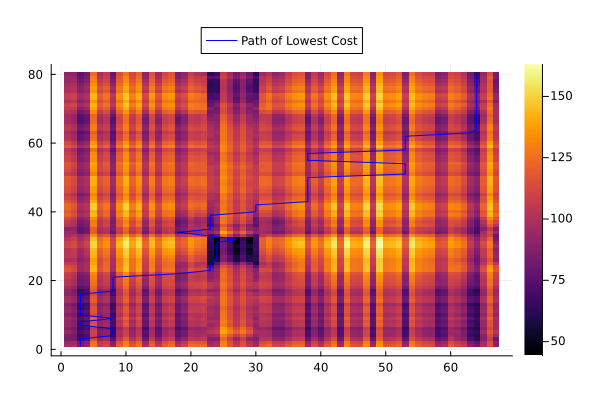

In [108]:
recording = WAV.wavread("rec_vcv1.wav")[1]
recording_mfcc = mfcc(recording, 44100, numcep=36, wintime=0.025, steptime=0.01)[1]
cost, path = get_cost_matrix(recording_mfcc, vcv1_simple_mfcc, 10)
heatmap(cost, legend=:outertop, margin=5*Plots.mm)
# plot!(1:length(cost[1, :]), 1:length(cost[:, 1]), label="Ideal Alignment")
plot!(path[1], path[2], label="Path of Lowest Cost", color=:blue)

In [109]:
alignment = get_alignment_curve(path)
peaks, magnitudes, centre, magnitude = get_potential_nudges(alignment, 8)

(Any[14, 22, 34, 47, 50, 51, 55, 63], Any[-11, -4, -16, -9, -12, 2, -17, 0], 38.5, -7.635)

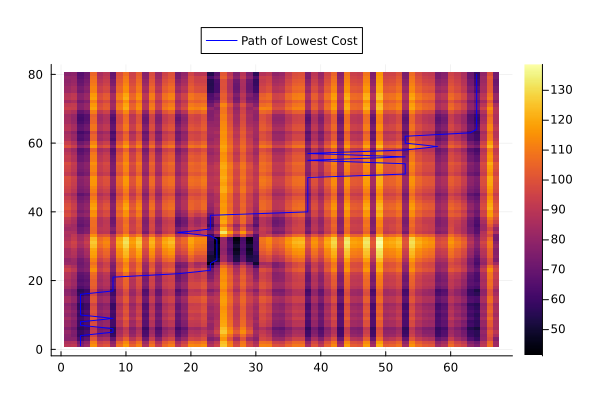

In [110]:
recording = WAV.wavread("rec_vcv1.wav")[1]
recording_mfcc = mfcc(recording, 44100, numcep=36, wintime=0.025, steptime=0.01)[1]
cost, path = get_cost_matrix(recording_mfcc[:, 1:24], vcv1_simple_mfcc[:, 1:24], 10)
heatmap(cost, legend=:outertop, margin=5*Plots.mm)
# plot!(1:length(cost[1, :]), 1:length(cost[:, 1]), label="Ideal Alignment")
plot!(path[1], path[2], label="Path of Lowest Cost", color=:blue)

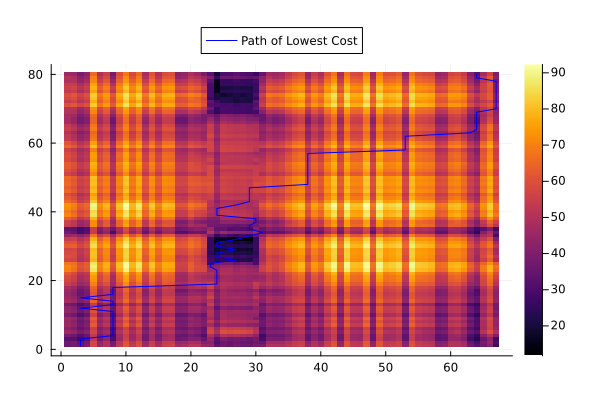

In [111]:
recording = WAV.wavread("rec_vcv1.wav")[1]
recording_mfcc = mfcc(recording, 44100, numcep=36, wintime=0.025, steptime=0.01)[1]
cost, path = get_cost_matrix(recording_mfcc[:, 24:end], vcv1_simple_mfcc[:, 24:end], 10)
heatmap(cost, legend=:outertop, margin=5*Plots.mm)
# plot!(1:length(cost[1, :]), 1:length(cost[:, 1]), label="Ideal Alignment")
plot!(path[1], path[2], label="Path of Lowest Cost", color=:blue)

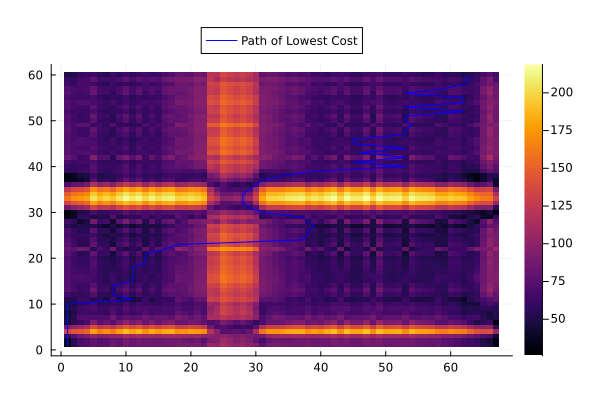

In [112]:
recording = WAV.wavread("synthesis.wav")[1]
recording_mfcc = mfcc(recording, 44100, numcep=36, wintime=0.025, steptime=0.01)[1]
cost, path = get_cost_matrix(recording_mfcc, vcv1_simple_mfcc, 10)
heatmap(cost, legend=:outertop, margin=5*Plots.mm)
# plot!(1:length(cost[1, :]), 1:length(cost[:, 1]), label="Ideal Alignment")
plot!(path[1], path[2], label="Path of Lowest Cost", color=:blue)